In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
import warnings
from mplsoccer.pitch import Pitch
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [3]:
match_html_path = r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Sunderland - Premier League 2025_2026 Live.html"
fotmob_matchId = 4813442

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)
dfp['shortName'] = dfp['name'].apply(get_short_name)

In [4]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'goalMouthZ', 'goalMouthY',
       'isGoal', 'isShot', 'blockedX', 'blockedY', 'cardType'],
      dtype='object')

In [5]:
dfp.columns

Index(['playerId', 'shirtNo', 'name', 'position', 'height', 'weight', 'age',
       'isFirstEleven', 'isManOfTheMatch', 'field', 'stats',
       'subbedInPlayerId', 'subbedOutPeriod', 'subbedOutExpandedMinute',
       'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId',
       'teamId', 'shortName'],
      dtype='object')

In [6]:
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

In [7]:
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

In [8]:
df['x'] = df['x']*1.2
df['y'] = df['y']*0.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*0.8
df['goalMouthY'] = df['goalMouthY']*0.8

In [9]:
columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 
                   'subbedInPlayerId', 'subbedOutPeriod', 
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

In [10]:
df = df.merge(dfp, on='playerId', how='left')

In [11]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'goalMouthZ', 'goalMouthY',
       'isGoal', 'isShot', 'blockedX', 'blockedY', 'cardType', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'shortName'],
      dtype='object')

In [12]:
df

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,...,blockedX,blockedY,cardType,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2.855487e+09,3,0,0.0,16,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Sunderland,Man Utd,NaN,NaN,NaN,NaN,NaN
1,2.855487e+09,3,0,0.0,32,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Sunderland,NaN,NaN,NaN,NaN,NaN
2,2.855487e+09,4,0,0.0,16,59.64,40.08,0,NaN,NaN,...,NaN,NaN,NaN,Sunderland,Man Utd,34.0,Granit Xhaka,DMC,True,G. Xhaka
3,2.855488e+09,5,0,4.0,16,26.76,47.60,0,NaN,NaN,...,NaN,NaN,NaN,Sunderland,Man Utd,22.0,Robin Roefs,GK,True,R. Roefs
4,2.855488e+09,4,0,9.0,32,32.64,52.40,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Sunderland,4.0,Matthijs de Ligt,DC,True,M. d. Ligt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,2.855721e+09,863,95,21.0,32,0.00,0.00,102,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Sunderland,NaN,NaN,NaN,NaN,NaN
1517,2.855721e+09,851,0,0.0,16,0.00,0.00,12,NaN,NaN,...,NaN,NaN,NaN,Sunderland,Man Utd,NaN,NaN,NaN,NaN,NaN
1518,2.855721e+09,864,0,0.0,32,0.00,0.00,12,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Sunderland,NaN,NaN,NaN,NaN,NaN
1519,2.855407e+09,2,0,0.0,32,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Sunderland,NaN,NaN,NaN,NaN,NaN


In [13]:
dfp

,playerId,shirtNo,name,position,isFirstEleven,shortName
0,402184,31,Senne Lammens,GK,True,S. Lammens
1,437299,15,Leny Yoro,DC,True,L. Yoro
2,320374,4,Matthijs de Ligt,DC,True,M. d. Ligt
3,118244,23,Luke Shaw,DC,True,L. Shaw
4,386634,16,Amad Diallo,DMR,True,A. Diallo
5,353418,2,Diogo Dalot,DML,True,D. Dalot
6,88526,18,Casemiro,MC,True,Casemiro
7,123761,8,Bruno Fernandes,MC,True,B. Fernandes
8,353377,19,Bryan Mbeumo,AMC,True,B. Mbeumo
9,343346,7,Mason Mount,AMC,True,M. Mount


In [14]:
df = df[
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['endX'].notna()) & 
    (df['endY'].notna())) | 
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['goalMouthY'].notna()))
]

In [15]:
df=df.reset_index()

In [16]:
df

,index,id,eventId,minute,second,teamId,x,y,expandedMinute,period,...,blockedX,blockedY,cardType,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2,2.855487e+09,4,0,0.0,16,59.64,40.08,0,NaN,...,NaN,NaN,NaN,Sunderland,Man Utd,34.0,Granit Xhaka,DMC,True,G. Xhaka
1,3,2.855488e+09,5,0,4.0,16,26.76,47.60,0,NaN,...,NaN,NaN,NaN,Sunderland,Man Utd,22.0,Robin Roefs,GK,True,R. Roefs
2,6,2.855488e+09,5,0,9.0,32,32.64,52.40,0,NaN,...,NaN,NaN,NaN,Man Utd,Sunderland,4.0,Matthijs de Ligt,DC,True,M. d. Ligt
3,8,2.855488e+09,7,0,11.0,32,46.44,34.08,0,NaN,...,NaN,NaN,NaN,Man Utd,Sunderland,19.0,Bryan Mbeumo,AMC,True,B. Mbeumo
4,9,2.855488e+09,8,0,12.0,32,57.12,41.04,0,NaN,...,NaN,NaN,NaN,Man Utd,Sunderland,30.0,Benjamin Sesko,FW,True,B. Sesko
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,1507,2.855720e+09,859,94,31.0,32,57.96,58.32,101,NaN,...,NaN,NaN,NaN,Man Utd,Sunderland,5.0,Harry Maguire,Sub,NaN,H. Maguire
1015,1511,2.855720e+09,845,94,36.0,16,57.84,32.16,101,NaN,...,NaN,NaN,NaN,Sunderland,Man Utd,9.0,Brian Brobbey,Sub,NaN,B. Brobbey
1016,1512,2.855721e+09,846,94,38.0,16,54.96,39.92,101,NaN,...,NaN,NaN,NaN,Sunderland,Man Utd,28.0,Enzo Le Fée,AMC,True,E. L. Fée
1017,1513,2.855721e+09,847,94,44.0,16,93.12,61.92,101,NaN,...,NaN,NaN,NaN,Sunderland,Man Utd,15.0,Omar Alderete,DC,True,O. Alderete


In [17]:
df=df[["minute","second","x","y","endX","endY","teamName","shirtNo","position","shortName","goalMouthY","isShot","isGoal"]]

In [18]:
df

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0.0,59.64,40.08,26.64,46.80,Sunderland,34.0,DMC,G. Xhaka,NaN,NaN,NaN
1,0,4.0,26.76,47.60,87.36,27.60,Sunderland,22.0,GK,R. Roefs,NaN,NaN,NaN
2,0,9.0,32.64,52.40,46.08,36.00,Man Utd,4.0,DC,M. d. Ligt,NaN,NaN,NaN
3,0,11.0,46.44,34.08,57.12,41.04,Man Utd,19.0,AMC,B. Mbeumo,NaN,NaN,NaN
4,0,12.0,57.12,41.04,56.28,55.28,Man Utd,30.0,FW,B. Sesko,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,94,31.0,57.96,58.32,72.00,63.44,Man Utd,5.0,Sub,H. Maguire,NaN,NaN,NaN
1015,94,36.0,57.84,32.16,54.96,39.36,Sunderland,9.0,Sub,B. Brobbey,NaN,NaN,NaN
1016,94,38.0,54.96,39.92,67.20,67.20,Sunderland,28.0,AMC,E. L. Fée,NaN,NaN,NaN
1017,94,44.0,93.12,61.92,120.00,30.72,Sunderland,15.0,DC,O. Alderete,NaN,NaN,NaN


In [19]:
df.to_csv("asfa.csv",index=False)

In [110]:
df.shortName.unique()

array(['G. Xhaka', 'R. Roefs', 'M. d. Ligt', 'B. Mbeumo', 'B. Sesko',
       'T. Hume', 'N. Sadiki', 'D. Dalot', 'N. Mukiele', 'M. Mount',
       'S. Lammens', 'L. Yoro', 'Casemiro', 'A. Diallo', 'A. Masuaku',
       'L. Shaw', 'O. Alderete', 'S. Adingra', 'B. Fernandes',
       'W. Isidor', 'E. L. Fée', 'B. Traoré', 'D. Ballard', 'C. Talbi',
       'E. Mayenda', 'P. Dorgu', 'M. Cunha', 'K. Mainoo', 'L. Geertruida',
       'B. Brobbey', 'M. Ugarte', 'H. Maguire'], dtype=object)

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_16800\212255957.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


60


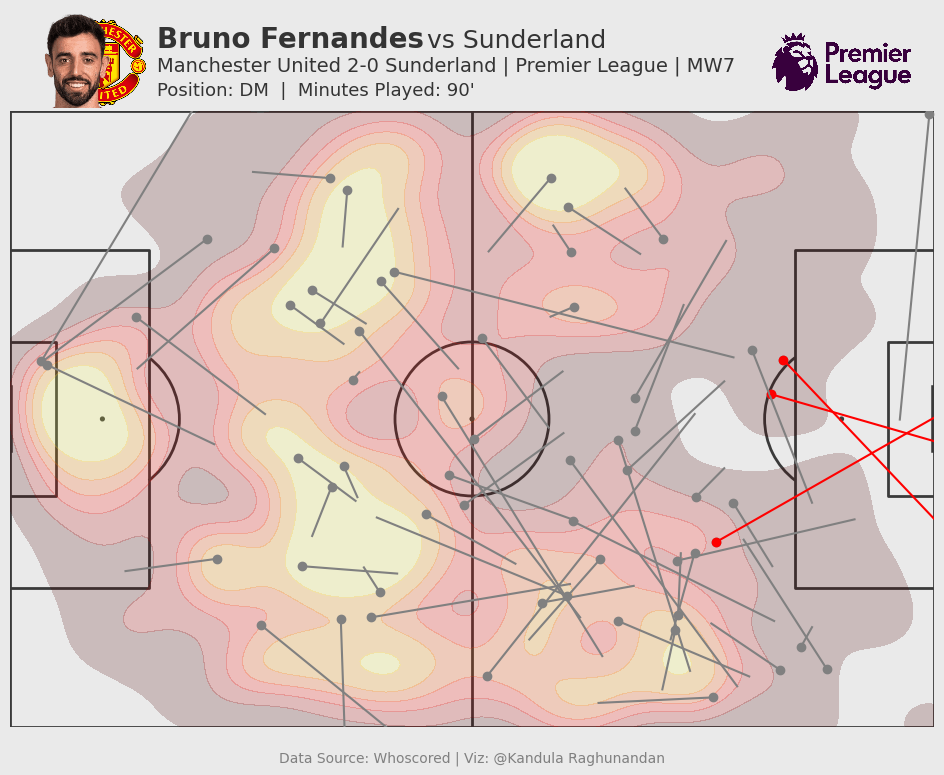

In [150]:
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    if df["shortName"][x]=="B. Fernandes":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    if (df["shortName"][x]=="B. Fernandes") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")

print(count)
        
fig.text(0.25, 0.96, "Bruno Fernandes", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.475,0.96,"vs Sunderland", fontsize = 18, color="#343434")
fig.text(0.25, 0.93, "Manchester United 2-0 Sunderland | Premier League | MW7", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.90, "Position: DM  |  Minutes Played: 90'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Bruno Fernandes.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.175, xy=(0.1, 1.079))
add_logo(ax, player_logo, zoom=0.35, xy=(0.072, 1.08))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig("C:/Users/K Raghunandan/Analyst/Results/Bruno_vs_sunderland_2025.png")